In [21]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import argrelextrema
from tqdm import tqdm
from itertools import product

def invert_image(image):
    return 255 - image

# Set rcParams to customize tick labels and spines
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['legend.loc'] = 'upper right'
plt.rcParams['axes.titlesize'] = 12

# Toy example for the classical Kalman Filter

## Continuous time signals $s_1(t) = cos(t)$ and $s_2(t) = cos(1.4 \cdot t+0.7)$

## Sampling $s(t)$ 

sampling time step dt      = 0.1 s
sampling frequency step df = 10.0 Hz
N = 200 samples


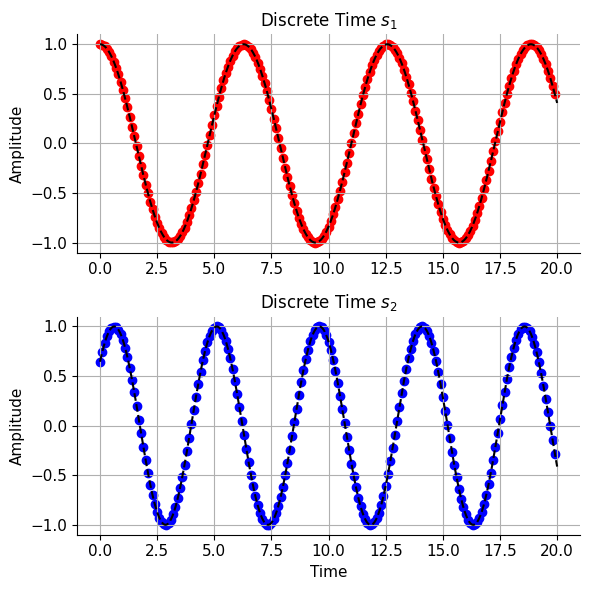

In [22]:
dt = 0.1   # Time step
N = 200    # Number of samples

print('sampling time step dt      =', dt, 's')
print('sampling frequency step df =', 1/dt, 'Hz')
print('N =', N, 'samples')

t = np.arange(0, N * dt, dt)  # Generates n points
s1 = np.cos(t)
s2 = np.sin(1.4*t + 0.7)
signals = np.array([s1, s2])

fig1, ax1 = plt.subplots(2, 1, figsize=(6, 6))

ax1[0].scatter(t, s1, color='r')
ax1[0].set_title('Discrete Time $s_1$')
# ax1[0].set_xlabel('Time')
ax1[0].set_ylabel('Amplitude')
ax1[0].plot(np.linspace(0, N*dt, 1000), np.cos(np.linspace(0, N*dt, 1000)), linestyle='--', color='k')

ax1[1].scatter(t, s2, color='b')
ax1[1].set_title('Discrete Time $s_2$')
ax1[1].set_xlabel('Time')
ax1[1].set_ylabel('Amplitude')
ax1[1].plot(np.linspace(0, N*dt, 1000), np.sin(1.4*np.linspace(0, N*dt, 1000)+0.7), linestyle='--', color='k')

fig1.tight_layout()

## Drawing signal $s$ in a pixel grid to create a raster image

To simplify the process, the image width is set equal to the number of samples in the signals. The signals are then rescaled in amplitude to fit within their assigned band of pixels in the raster image.

In [23]:
### Parameters

# size of the pixels grid
height = 100
width = 200

# margins
t_margin = 5
l_margin = 0
r_margin = 0
b_margin = 5

line_thickness = 1 # pixels

overlap_percentages = np.linspace(0, 0.3, 100)
###

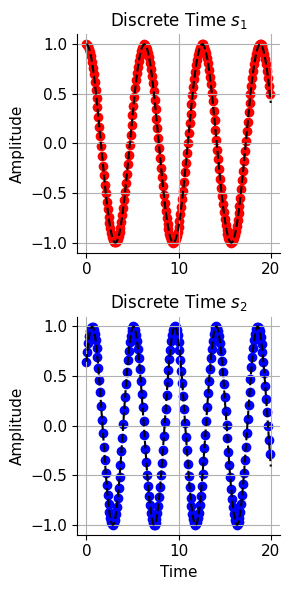

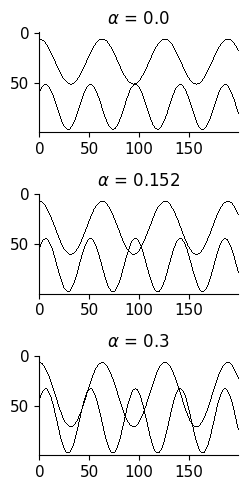

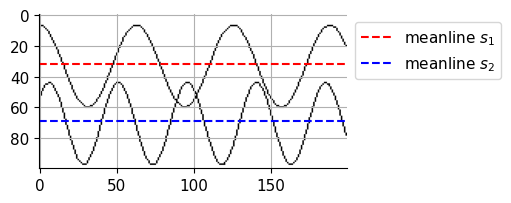

In [24]:
images = []

# Save the scaled signal as GT for each overlap and for each signal
GTs = np.zeros((len(overlap_percentages), len(signals), N))

for l, overlap_percentage in enumerate(overlap_percentages):
    background = np.full((height, width), 255, dtype=np.int32)  # background of binary image

    num_signals = len(signals)
            
    available_height = height - t_margin - b_margin  # Space available for signals
    max_amplitude = (available_height / num_signals) / (1 - overlap_percentage)  # Control overlap
            
    # Create vertical offsets while considering margins and overlap
    vertical_offsets = np.linspace(t_margin + max_amplitude / 2, height - b_margin - max_amplitude / 2, num_signals)
    if overlap_percentage == overlap_percentages[len(overlap_percentages)//2]:
        vertical_offset = vertical_offsets

    # Horizontal shifting
    available_width = width - l_margin - r_margin
    horizontal_offsets = l_margin
    for i, signal in enumerate(signals):
        # Center, normalize and scale signal
        signal = (signal - np.mean(signal)) / np.max(np.abs(signal))  # Center and normalize
        scaled_signal = (max_amplitude / 2) * signal + vertical_offsets[len(signals)-1-i]  # Rescale amplitude to fit within frame
        # scaled_signal = available_height - scaled_signal
                
        # Create x-coordinates for plotting with horizontal offset
        x_coords = np.linspace(0, available_width - 1, len(signal)).astype(np.int32) + horizontal_offsets
        y_coords = scaled_signal.astype(np.int32)  # Ensure y-coordinates stay in bounds

        # Save GT
        GTs[l, i] =  height-y_coords
                
        # plt.scatter(x_coords, y_coords, color='r')
        # plt.show()

        # Draw 
        for j in range(1, len(x_coords)):
            cv2.line(background, (x_coords[j-1], height-y_coords[j-1]), (x_coords[j], height-y_coords[j]), 0, line_thickness)

    images.append(background)

images = np.array(images)

# Display the images
fig1, ax1 = plt.subplots(2, 1, figsize=(3, 6))

ax1[0].scatter(t, s1, color='r')
ax1[0].set_title('Discrete Time $s_1$')
# ax1[0].set_xlabel('Time')
ax1[0].set_ylabel('Amplitude')
ax1[0].plot(np.linspace(0, N*dt, 1000), np.cos(np.linspace(0, N*dt, 1000)), linestyle='--', color='k')

ax1[1].scatter(t, s2, color='b')
ax1[1].set_title('Discrete Time $s_2$')
ax1[1].set_xlabel('Time')
ax1[1].set_ylabel('Amplitude')
ax1[1].plot(np.linspace(0, N*dt, 1000), np.sin(1.4*np.linspace(0, N*dt, 1000)+0.7), linestyle='--', color='k')

fig1.tight_layout()

fig1.savefig(f'results/signals_V.pdf', format='pdf', bbox_inches='tight', dpi=300)

fig2, ax2 = plt.subplots(3, 1, figsize=(3, 5))
titles = [overlap_percentages[0], overlap_percentages[len(overlap_percentages)//2], overlap_percentages[-1]]
for i, image in enumerate([images[0], images[len(images)//2], images[-1]]):
    ax2[i].set_title(r'$\alpha$ = ' + str(np.round(titles[i], 3)))
    ax2[i].imshow(image, cmap='gray', vmin=0, vmax=255)
    # ax2[i].axis('off')
    ax2[i].grid(False)
# Show the plot

fig2.tight_layout()
fig2.savefig(f'results/overlap_v.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

# Save images[2] to a pdf file
fig, ax = plt.subplots(figsize=(6, 2))
ax.imshow(images[len(images)//2], cmap='gray', vmin=0, vmax=255)
# trace horizontal lines 
colors = ['r', 'b']
for i, offset in enumerate(vertical_offset):
    ax.axhline(y=offset, linestyle='--', color=colors[i], label='meanline $s_{}$'.format(i+1))
ax.legend(loc='upper left', bbox_to_anchor=(1, 1)) 
# ax.axis('off')
fig.savefig('overlap_0.2.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

In [25]:
inverted_images = np.array([invert_image(image) for image in images]) / np.max(images)
all_x_0 = np.array(GTs[:, :, 0]) # Given

# for inverted_image in inverted_images:
#     print(np.where(inverted_image[:, 0] > 1e-16))
    # # find the len(signals) local maxima of inverted_image[:, 0] using argrelextrema
    # min_indices = argrelextrema(inverted_image[:, 0], np.less, order=1)[0]
    # print(min_indices)
    # # sorted_minima = min_indices[np.argsort(inverted_image[min_indices])]

## Evalutate the resulted tracked curves wrt to the GT

In [ ]:
def compute_MSE(estimated_positions, GTs):
    """
    Compute the Mean Squared Error between the estimated positions and the GTs.

    Args:
        estimated_positions (np.ndarray): Shape (M, N) - N estimated positions for M traces.
        GTs (np.ndarray): Shape (M, N) - N GTs for M traces.

    Returns:
        mse (float): MSE for all traces.
    """
    # Compute the MSE between the estimated positions and the GTs
    if len(estimated_positions) != len(GTs):
        raise ValueError('The number of traces in the estimated positions and GTs must be the same.')
    mse = 0
    for i in range(len(GTs)):
        mse += np.mean((estimated_positions[i] - GTs[i])**2)
    return mse / len(GTs)

## Implement the KF on the raster image

### State Transition Model

The state $i$ at time $k$ is defined as
$$
\mathbf{x}^i_k = \begin{bmatrix} p \\ v \end{bmatrix}
$$
where:
- $p$ is the position in the vertical direction.
- $v$ is the velocity in the vertical direction.

Note that the vertical direction corresponds to the vertical axis of the raster image. Moreover, for clarity, the index $i$ will be omitted whenever it does not cause any ambiguity.

The state transition model for a constant velocity motion in 2D is given by:
$$
\mathbf{x}_{k+1} = \mathbf{A} \mathbf{x}_k + \mathbf{w}_k
$$
Where:
- $\mathbf{x}_{k+1}$ is the state at time $k+1$.
- $\mathbf{x}_k$ is the state at time $k$.
- $\mathbf{A} = \begin{bmatrix}
1 & \Delta t \\
0 & 1 \end{bmatrix}$ is the state transition matrix.
- $\mathbf{w}_k \sim \mathcal{N}(\mathbf{0}, \mathbf{Q})$ is the process noise at time $k$.

The measurement model is:
$$
\mathbf{z}_k = \mathbf{H} \mathbf{x}_k + \mathbf{v}_k
$$
Where:
- $\mathbf{z}_k$ is the measurement at time $k$.
- $\mathbf{H} = \begin{bmatrix}
1 & 0 \end{bmatrix}$ is the measurement matrix.
- $\mathbf{v}_k \sim \mathcal{N}(\mathbf{0}, \mathbf{R})$ is the measurement noise at time $k$.

Both $\mathbf{w}_k$ and $\mathbf{v}_k$ are white noise processes.

### Prediction and Update for Weighted Kalman Filter

1. **Prediction Step:**

The prediction step involves predicting the state at time $k+1$ using the state at time $k$ and the state transition model.

- **Predicted state estimate:**
$$
\hat{\mathbf{x}}_{k+1|k} = \mathbf{A} \hat{\mathbf{x}}_{k|k}
$$

- **Predicted covariance estimate:**
$$
\mathbf{P}_{k+1|k} = \mathbf{A} \mathbf{P}_{k|k} \mathbf{A}^T + \mathbf{Q}
$$
Where:
- $\hat{\mathbf{x}}_{k+1|k}$ is the predicted state estimate.
- $\mathbf{P}_{k+1|k}$ is the predicted covariance estimate.
- $\mathbf{P}_{k|k}$ is the current state covariance estimate.

2. **Weighted Update Step:**

Once multiple measurements $\mathbf{z}_k$ are available, the update step corrects the predicted state and covariance using a weighting mechanism based on the association probabilities.

- **Innovation covariance and Kalman Gain for each track:**
$$
\mathbf{S}_i = \mathbf{H} \mathbf{P}_i \mathbf{H}^T + \mathbf{R}
$$
$$
\mathbf{K}_i = \mathbf{P}_i \mathbf{H}^T \mathbf{S}_i^{-1}
$$
Where:
- $\mathbf{S}_i$ is the innovation covariance for the $i$-th trace.
- $\mathbf{K}_i$ is the Kalman gain for the $i$-th trace.

- **Compute association probabilities using Mahalanobis distance:**

The association probability $\beta_{ij}$ between the $i$-th trace and the $j$-th measurement is computed as:
$$
\beta_{ij} = \frac{\exp\left(-\frac{1}{2} d_{ij}\right)}{\sum_j \exp\left(-\frac{1}{2} d_{ij}\right) + P_{fa}}
$$
Where:
- $d_{ij} = (\mathbf{z}_j - \mathbf{H} \mathbf{x}_i)^T \mathbf{S}_i^{-1} (\mathbf{z}_j - \mathbf{H} \mathbf{x}_i)$ is the Mahalanobis distance.
- $P_{fa}$ is a false alarm probability.

- **Update states using weighted innovation:**

The weighted innovation is computed as:
$$
\Delta \mathbf{x}_i = \sum_j \beta_{ij} (\mathbf{z}_j - \mathbf{H} \mathbf{x}_i)
$$

- **Updated state estimate:**
$$
\hat{\mathbf{x}}_{k|k} = \hat{\mathbf{x}}_{k|k-1} + \mathbf{K}_i \Delta \mathbf{x}_i
$$

- **Updated covariance estimate:**
$$
\mathbf{P}_{k|k} = (\mathbf{I} - \beta_i \mathbf{K}_i \mathbf{H}) \mathbf{P}_{k|k-1} (\mathbf{I} - \beta_i \mathbf{K}_i \mathbf{H})^T + \mathbf{K}_i (\sum_j \beta_{ij}^2 \mathbf{R}) \mathbf{K}_i^T
$$

Where:
- $\beta_i = \sum_j \beta_{ij}$ represents the total association probability for track $i$.
- $\hat{\mathbf{x}}_{k|k}$ is the updated state estimate.
- $\mathbf{P}_{k|k}$ is the updated covariance estimate.
- $\mathbf{I}$ is the identity matrix.

This weighted update approach ensures that the state is updated in a probabilistic manner, accounting for multiple possible measurements while mitigating false detections.


#### Choice of $\Delta t$

Assuming no corruption of the time axis of the raster image (the horizontal axis), the formula is:
$$ \Delta t = \frac{\text{available\_width}}{N_{\text{samples}} - 1} $$

In our case, $$\Delta t = 1 \quad \text{pixels}$$.

In [27]:
# Define the prediction step
def predict(X, P, A, Q):
    # check if X has 1 or 2 dimension(s)
    if len(X.shape) == 1:
        X = A @ X
        P = A @ P @ A.T + Q
    else:
        # multiple states in parallel
        for i in range(X.shape[0]):
            X[i] = A @ X[i]
            P[i] = A @ P[i] @ A.T + Q
        # X = (A @ X.T).T  # Batch multiply all rows of X at once
        # P = A @ P @ A.T + Q  # Assuming P is (N, M, M), use batch multiplication
    return X, P

def update(x, P, z, H, R):
    S = H @ P @ H.T + R
    K = P @ H.T @ np.linalg.inv(S)
    x = x + K @ (z - H @ x)
    P = P - K @ H @ P
    return x, P

In [28]:
def weighted_update(X, P, Z, H, R, P_fa=1e-2):
    """
    Perform the Kalman filter update step using the JPDA approach for multiple traces.

    Args:
        X (np.ndarray): Shape (N, n) - Predicted state estimates for N traces.
        P (np.ndarray): Shape (N, n, n) - Predicted covariance matrices for N traces.
        Z (np.ndarray): Shape (M, m) - Measurements for M detections, m=1.
        H (np.ndarray): Shape (m, n) - Observation matrix.
        R (np.ndarray): Shape (m, m) - Measurement noise covariance, m=1.

    Returns:
        X_updated (np.ndarray): Shape (N, n) - Updated state estimates.
        P_updated (np.ndarray): Shape (N, n, n) - Updated covariance matrices.
    """
    # print("X : ", type(X[0,0]))
    # print("P : ", type(P[0,0,0]))
    # print("Z : ", type(Z[0]))
    # print("H : ", type(H[0,0]))
    # print("R : ", type(R[0,0]))
    N, n = X.shape  # Number of traces, state dimension
    M = Z.shape[0]      # Number of measurements
    # m = Z.shape[1]      # Measurement dimension
    m = 1
    
    X_updated = np.copy(X)
    P_updated = np.copy(P)
    
    # Compute innovation covariance and Kalman gains
    S = np.zeros((N, m, m))  # Innovation covariance for each trace
    K = np.zeros((N, n, m))  # Kalman gain for each trace
    for i in range(N):
        S[i] = H @ P[i] @ H.T + R               # Innovation covariance
        # print(i, S[i], K[i])
        K[i] = P[i] @ H.T @ np.linalg.inv(S[i]) # Kalman gain

    # Compute association probabilities β_ij using Mahalanobis distance
    beta = np.zeros((N, M))
    likelihoods = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            residual = Z[j] - H @ X[i]  # Innovation (measurement residual)
            # print('res',i, j, residual)
            mahalanobis_dist = residual.T @ np.linalg.inv(S[i]) @ residual  # Mahalanobis distance
            # print(i, j, mahalanobis_dist)
            likelihoods[i, j] = np.exp(-0.5 * mahalanobis_dist) / np.sqrt((2*np.pi)**m*np.linalg.det(S[i]))
            # print(i, j, likelihoods[i, j],"-",  np.exp(-0.5 * mahalanobis_dist),"-", -0.5*mahalanobis_dist )

    # Normalize probabilities
    # print("lik", likelihoods)
    for i in range(N):
        beta[i, :] = likelihoods[i, :] / (np.sum(likelihoods[i, :]) + P_fa)  # Avoid division by zero

    # Update states using weighted innovation
    for i in range(N):
        weighted_innovation = np.zeros((m, 1))
        for j in range(M):
            weighted_innovation += beta[i, j] * (Z[j] - H @ X[i])
        # Update state and covariance
        beta_i = np.sum(beta[i, :])
        X_updated[i] = X[i] + (K[i] @ weighted_innovation).ravel() # ! Check if this is correct
        temp = (np.eye(n) - beta_i * K[i] @ H)
        P_updated[i] = temp @ P[i] @ temp.T + K[i] @ (np.sum(beta[i, :]**2) * R) @ K[i].T


    return X_updated, P_updated, beta

### Find good parameters

Dt: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]

Best parameters: {'Dt': 0.5, 'sigma_p': 0.01, 'sigma_v': 2, 'sigma_z': 0.25, 'p_fa': 0.0001}
Minimum MSE: 0.4073720581866458


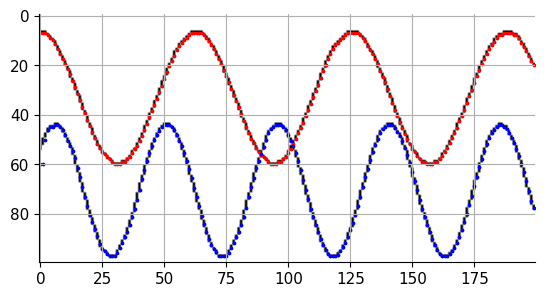

In [ ]:
### 
# Weighted Kalman filter
###

### Parameters
Dts = [0.5] # np.linspace(0.5, 5, 2) # Time step related to the state transition matrix A, ! different than sampling rate dt of signal s

# Assuming no process noise
sigma_ps = [0.01] # np.linspace(1e-2, 2, 2) 
sigma_vs = [2] # np.linspace(1e-2, 2, 2)

# Assuming no measurement noise
sigma_zs = [0.25] # np.linspace(1e-6, 1, 5)

p_fas = [0.0001] # np.linspace(1e-4, 1, 5)
###

# Select an overlap percentage
sel = len(overlap_percentages)//2

min_MSE = np.inf
best_params = {}
best_result = None

for Dt in tqdm(Dts, desc='Dt'):
    for sigma_p in sigma_ps:
        for sigma_v in sigma_vs:
            for sigma_z in sigma_zs:
                for p_fa in p_fas:
                    A = np.array([[1, Dt],
                                [0, 1]]).astype(np.float64)
                    
                    H = np.array([[1, 0]]).astype(np.float64)

                    Q = np.array([[sigma_p**2, 0],
                                [0, sigma_v**2]])

                    R = np.array([[sigma_z**2]])

                    # Initial state covariance given all_x_0
                    P = np.zeros((2, 2))
                    P[1, 1] = 10

                    x_0 = all_x_0[1]
                    X_weighted = np.array([[x_0[0], 0], [x_0[1], 0]]).astype(np.float64)
                    P_weighted = np.array([np.copy(P), np.copy(P)]).astype(np.float64)

                    tresh = 1e-2

                    image = inverted_images[sel]

                    avg_N_components = 2

                    estimated_positions_weighted = [[] for _ in range(avg_N_components)] # shape (N_components, N)
                    estimated_positions_weighted[0].append(X_weighted[0, 0])
                    estimated_positions_weighted[1].append(X_weighted[1, 0])

                    for k in range(1, image.shape[1]):
                        col = image[:, k]
                        # find the non 0 value pixels, with a given treshold
                        measurements = (np.where(col > tresh)[0]).astype(np.float64)

                        # Predict
                        X_w, P_w = predict(X_weighted, P_weighted, A, Q)
                        # Weighted Update
                        X_weighted, P_weighted, beta = weighted_update(X_w, P_w, measurements, H, R, p_fa)
                        # print("beta", beta)
                        for i in range(avg_N_components):
                            # Save the estimated position
                            estimated_positions_weighted[i].append(X_weighted[i, 0])

                    # Compute MSE for the weighted Kalman filter

                    MSE = compute_MSE(estimated_positions_weighted, GTs[sel])
                    if MSE < min_MSE:
                        min_MSE = MSE
                        best_params = {'Dt': Dt, 'sigma_p': sigma_p, 'sigma_v': sigma_v, 'sigma_z': sigma_z, 'p_fa': p_fa}
                        best_result = estimated_positions_weighted

print('Best parameters:', best_params)
print('Minimum MSE:', min_MSE)

# plot the best estimated positions
plt.imshow(images[sel], cmap='gray', vmin=0, vmax=255)
plt.scatter(np.arange(0, len(best_result[0])), best_result[0], color='r', s=3)
plt.scatter(np.arange(0, len(best_result[1])), best_result[1], color='b', s=3)
plt.show()

### Evaluate the method for different degrees of overlap

Overlap percentage: 100it [00:09, 10.07it/s]


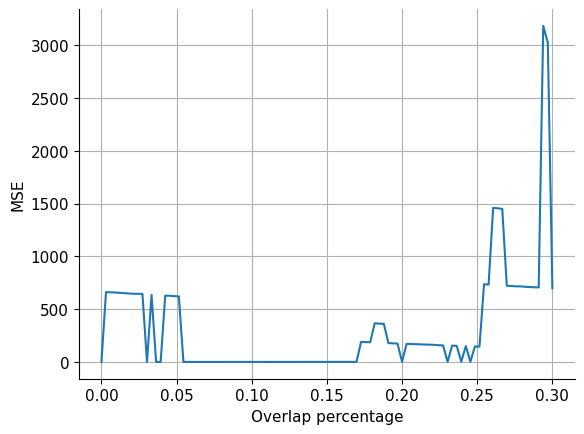

In [30]:
Dt = best_params['Dt']
sigma_p = best_params['sigma_p']
sigma_v= best_params['sigma_v']
sigma_z = best_params['sigma_z']
p_fa = best_params['p_fa']

A = np.array([[1, Dt],
            [0, 1]]).astype(np.float64)

H = np.array([[1, 0]]).astype(np.float64)

Q = np.array([[sigma_p**2, 0],
            [0, sigma_v**2]])
    
R = np.array([[sigma_z**2]])

MSE_list = []

# Initial state covariance given all_x_0
for sel, overlap_percentage in tqdm(enumerate(overlap_percentages), desc='Overlap percentage'):
    P = np.zeros((2, 2))
    P[1, 1] = 10

    x_0 = all_x_0[1]
    X_weighted = np.array([[x_0[0], 0], [x_0[1], 0]]).astype(np.float64)
    P_weighted = np.array([np.copy(P), np.copy(P)]).astype(np.float64)

    tresh = 1e-2

    image = inverted_images[sel]

    avg_N_components = 2

    estimated_positions_weighted = [[] for _ in range(avg_N_components)] # shape (N_components, N)
    estimated_positions_weighted[0].append(X_weighted[0, 0])
    estimated_positions_weighted[1].append(X_weighted[1, 0])

    for k in range(1, image.shape[1]):
        col = image[:, k]
        # find the non 0 value pixels, with a given treshold
        measurements = (np.where(col > tresh)[0]).astype(np.float64)

        # Predict
        X_w, P_w = predict(X_weighted, P_weighted, A, Q)
        # Weighted Update
        X_weighted, P_weighted, beta = weighted_update(X_w, P_w, measurements, H, R, p_fa)
        # print("beta", beta)
        for i in range(avg_N_components):
            # Save the estimated position
            estimated_positions_weighted[i].append(X_weighted[i, 0])

    # Compute MSE for the weighted Kalman filter
    MSE = compute_MSE(estimated_positions_weighted, GTs[sel])
    MSE_list.append(MSE)

# plot MSE vs overlap percentage
plt.plot(overlap_percentages, MSE_list)
plt.xlabel('Overlap percentage')
plt.ylabel('MSE')
plt.show()
